## Load relevant packages

In [1]:
# Import all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Descriptive data analysis on global dataset

### Functions we'll need to make histogram plots, bar plots, and error bars

In [3]:
# FROM HERE ON IT'S AUTOMATIC

# This function takes a dataframe and a column with categorical data and gives the number 
# of occurrances of each distinct entry, with error bars (which are computer by bootstrapping).
# The output is given in the form {distinctentry: [total(on average),errorbars], ...}
def getCompositionAndErrorbar(thedataframe, columnname, num_iterations = 1000, normalized=False):
    categories = thedataframe[columnname].unique()
    sizesample = thedataframe.shape[0]
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        totalsofcategories = [(sampledcolumn == cat).sum() for cat in categories]
        sampletotals.append(totalsofcategories)
    sampletotals = np.transpose(np.array(sampletotals))
    if normalized==True:
        numofcasesanderrors = dict([(categories[ij], 
                                     [totals.mean() / float(sizesample), totals.std() / float(sizesample)]) 
                                    for (ij,totals) in enumerate(sampletotals)])
    else:
        numofcasesanderrors = dict([(categories[ij], [totals.mean(), totals.std()]) for (ij,totals) in enumerate(sampletotals)])
    return numofcasesanderrors

# Takes the output of getCompositionAndErrorbar and turns it into a dataframe
def turnValueAndErrorIntoFrame(totalsanderrors):
    indices = list(totalsanderrors)
    mean_and_std_dataframe = pd.DataFrame({"Mean": [totalsanderrors[ind][0] for ind in indices], 
              "StandardDeviation": [totalsanderrors[ind][1] for ind in indices]}, index=indices).sort_index()
    return mean_and_std_dataframe
    
# Draws a barplot showing the total number of elements in a given column of a given dataframe,
# with error bars, using the function getCompositionAndErrorbar. This is intended for use in categorical columns.
def drawBarPlotOfTotals(thedataframe, columnname, num_iterations = 1000, placeinax="none"):
    totalsanderrors = getCompositionAndErrorbar(thedataframe,columnname,num_iterations=num_iterations)
    mean_and_std_dataframe = turnValueAndErrorIntoFrame(totalsanderrors)
    if placeinax=="none":
        mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"])
        plt.xlabel(columnname)
        plt.ylabel("Total")
        plt.title("Composition of "+columnname)
        plt.show()
    else:
        mean_and_std_dataframe["Mean"].plot.bar(yerr=mean_and_std_dataframe["StandardDeviation"], ax=placeinax)
        placeinax.set_xlabel(columnname)
        placeinax.set_ylabel("Total")
        placeinax.set_title("Composition of "+columnname)
        

# Returns the error bars and bins of a histogram of a quantitative column by bootstrapping the histogram counts
def getHistogramErrorbar(thedataframe, columnname, num_iterations = 1000, normalized=False, inputbins="none"):
    sizesample = thedataframe.shape[0]
    if type(inputbins)==str and inputbins=="none":
        binstouse = np.histogram(thedataframe[columnname])[1]
    else:
        binstouse = inputbins
    sampletotals = []
    for ii in range(num_iterations):
        sampledcolumn = thedataframe.sample(n=sizesample, replace=True)[columnname]
        sampletotals.append(np.histogram(sampledcolumn, bins=binstouse))
    binvalues = np.transpose(np.array([histogramvalues[0] for histogramvalues in sampletotals]))
    if normalized==True:
        histogramdata = ([binval.std()/(float(sizesample)*(binstouse[-1]-binstouse[-2])) for binval in binvalues], binstouse)
    else:
        histogramdata = ([binval.std() for binval in binvalues], binstouse)
    return histogramdata

# Draws a histogram of a given quantitative column of a given dataframe,
# with error bars, using the function getHistogramErrorbar.
def drawHistogramWithErrorbars(thedataframe, columnname, num_iterations = 1000, placeinax="none"):
    (histerrorbars, bins) = getHistogramErrorbar(thedataframe, columnname, num_iterations)
    if placeinax=="none":
        (n, bins, _) = plt.hist(thedataframe[columnname], bins=bins, histtype = 'step')
    else:
        (n, bins, _) = placeinax.hist(thedataframe[columnname], bins=bins, histtype = 'step')
    mid = 0.5*(bins[1:] + bins[:-1])
    if placeinax=="none":
        plt.errorbar(mid, n, yerr=histerrorbars, fmt='none')
        plt.xlabel(columnname)
        plt.ylabel("Total")
        plt.title("Distribution of "+columnname)
        plt.show()
    else:
        placeinax.errorbar(mid, n, yerr=histerrorbars, fmt='none')
        placeinax.set_xlabel(columnname)
        placeinax.set_ylabel("Total")
        placeinax.set_title("Distribution of "+columnname)
    
# This high-level function goes through all columns in a dataframe and makes a plot of each of the
# features. It needs to know what types of data we have, which columns it should skip (uselesscols)
# and a dictionary that says which rows of the data constitute NaNs that have been filled in automatically
def descriptiveAnalysisAllColumns(inputdataframe, datacateg, uselesscols, dictofunknown):
    validcolumnstoplot = [col for col in inputdataframe if (datacateg[col] in ["C","O","QA","QC"] and (col not in uselesscols))]
    numberofrows = int(np.ceil(len(validcolumnstoplot) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax,col) in zip(axes.ravel(), validcolumnstoplot):
        if (datacateg[col]=="C" or datacateg[col]=="O") and (col not in uselesscols):
            if col in dictofunknown:
                drawBarPlotOfTotals(inputdataframe[inputdataframe[col]!= dictofunknown[col]], col, placeinax=currentax)
            else:
                drawBarPlotOfTotals(inputdataframe, col, placeinax=currentax)
        if (datacateg[col]=="QA" or datacateg[col]=="QC") and (col not in uselesscols):
            if col in dictofunknown:
                drawHistogramWithErrorbars(inputdataframe[inputdataframe[col]!= dictofunknown[col]], col, placeinax=currentax)
            else:
                drawHistogramWithErrorbars(inputdataframe, col, placeinax=currentax)

### Determine category of data and what to plot. Then plot the data for the full dataset.

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:


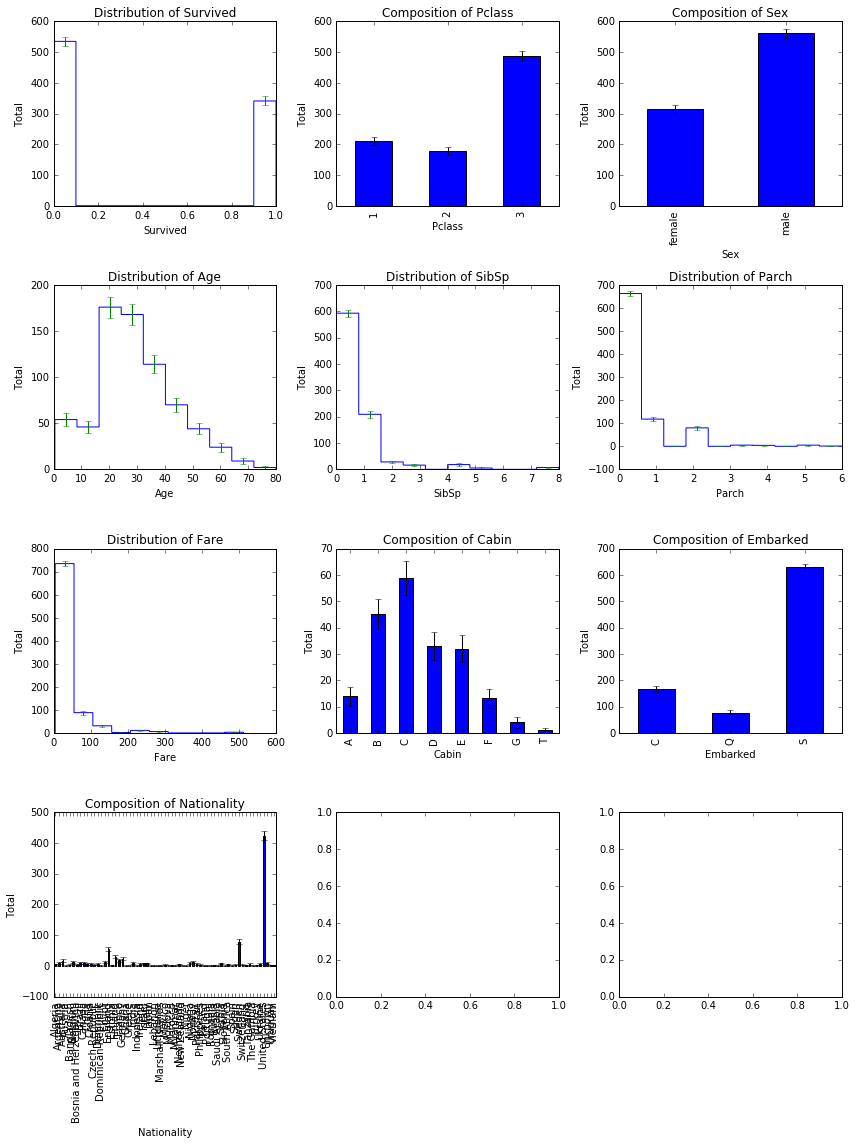

In [187]:
#================================================================================================
# USER INPUT!
# We shall now do som  global exploratory analysis on our data. We will later segment the data and
# perform an analysis on each 
# We need to know what category of data we have in each column: 
# - "C": categorical (can do =, !=)
# - "O": ordinal (can do =, !=, >, <)
# - "QC": quantative comparison (zero unimportant, e.g. time stamps) (can do =, !=, >, <, +, -)
# - "QA": quantative absolute (zero important, e.g. length) (can do =, !=, >, <, +, -, * , /)
# This information will be in the form of a dictionary, for each data table

datacategories = [ # we put "Survived" as "QA" because we interpret it as a survival probability
    {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C", 
     'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
     'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
]

# It is useless to find the copmosition of certain columns, since they are nearly all different
# and are hence more similar to a unique identifier
uselesscolumns = [
    ["Name", "Ticket"]
]

# In each column, some entries are unknown and have been filled by by e.g. "X". We would
# like to remove these when looking at the compositions. You might need to look in the 
# CleaningNotebook to find out what the unknown entries are called
unknowns = [
    {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
     "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
     "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0]}
]

#================================================================================================

# FROM HERE ON IT'S AUTOMATIC
# We'll first do some descriptive work on our data: for "C" and "O", it's good to know the 
# proportions of each of the categories (and their total). For "QC" and "QA" we would like to have a 
# distribution of the data. Ideally, we would always like to see error bars on everything.

for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    descriptiveAnalysisAllColumns(alldataframes[ii], datacategories[ii], uselesscolumns[ii], unknowns[ii])

# Descriptive data analysis on segmented dataset

Now we'll work on segmented data. For each segment we'll plot the other features. Each time we plot a feature we also compare the result to the global data, i.e. the data from the full dataset.

### Functions we'll need to make histogram plots, bar plots, and error bars

In [5]:
def segmentAndDrawCategoricalColumn(thedataframe, segmentationcolumn, columnname, segmentcolnumeric=False):
    # We'll first make a dataframe containing the barplot-information of the global data, i.e. of
    # the data on the full dataset.
    compositiondataframeglobal = turnValueAndErrorIntoFrame(getCompositionAndErrorbar(thedataframe,columnname, normalized=True))
    # We rename the columns for the global data so that column-names don't clash with other dataframes.
    compositiondataframeglobal = compositiondataframeglobal.rename(
        index=str, columns={"Mean": "Global", "StandardDeviation": "StandardDeviationGlobal"})
    # This will be the maximum yvalue on the plots (purely aesthetic)
    ymax = max(compositiondataframeglobal["Global"]+ compositiondataframeglobal["StandardDeviationGlobal"])
    # Now we'll segment the dataframe according to the column called segmentationcolumn
    if segmentcolnumeric==True:
        globalbins = np.histogram(thedataframe[segmentationcolumn])[1]
        # shift the last bin by 1% further away so as to include the endpoint 
        # (unfortunately pd.cut has no in-built way of doing it when right==True because there is no option
        # include_highest)
        globalbins[-1] = 1.01*globalbins[-1] - 0.01*globalbins[-2]
        allsegments = thedataframe.groupby(pd.cut(thedataframe[segmentationcolumn], globalbins, right=False))
        # In the groupby object we created we may have empty groups (which do not contribute to len(allsegments),
        # i.e. iterating over allsegments gives something longer than len(allsegments)). We will remove the empty groups,
        # turning the groupby object into an orderinary list of tuples.
        segmentedframe = []
        for (segmentvalue,subframe) in allsegments:
            if len(subframe)>0:
                segmentedframe.append((segmentvalue,subframe))
    else:
        allsegments = thedataframe.groupby(segmentationcolumn)
        # If we have too many categories (i.e. more than 12), only draw those that have at least 4% of the
        # total amount of data
        if len(allsegments)>=12:
            minnumberofrows = np.floor(len(thedataframe)*0.04)
            segmentedframe = []
            for (segmentvalue,subframe) in allsegments:
                if len(subframe)>minnumberofrows:
                    segmentedframe.append((segmentvalue,subframe))
        else:
            segmentedframe = allsegments
    # For each segment of the data, we'll make a barplot of the data in columnname, and compare it with the
    # same barplot for the global data.
    # We'll put all the frames in an array of subplots, as described in the pandas documention. In
    # this case we'll draw three columns and as many rows as needed.
    numberofrows = int(np.ceil(len(segmentedframe) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    # Now we'll go through the segments of the data, in each case making a dataframe containing the information
    # that needs to be passed to the barplot. We then plot the barplot alongside that of the global data,
    # placing it in the current subplot called currentax.
    for (currentax, (segmentvalue,subframe)) in zip(axes.ravel(), segmentedframe):
        # First we get a dictionary containing the barplot data, i.e. the totals plus error bars
        totalsanderrors = getCompositionAndErrorbar(subframe.drop(segmentationcolumn, 1),columnname, normalized=True)
        # Then we turn it into a dataframe which is easily plotted with pandas
        compositiondataframesegment = turnValueAndErrorIntoFrame(totalsanderrors)
        # We might need to update our ymax
        possiblenewmax = max(compositiondataframesegment["Mean"] + compositiondataframesegment["StandardDeviation"] )
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        # Since the name of the column will appear on the plot, we rename it to something less generic
        compositiondataframesegment = compositiondataframesegment.rename(index=str, columns={"Mean": "Segment"})
        # Now we'll put together the frame containing the segmented data and the frame containing the global data
        frametoplot = pd.concat([compositiondataframesegment, compositiondataframeglobal], axis=1).fillna(0)
        # We also get the error bars of each barplot
        errorbarsofplot = [frametoplot["StandardDeviation"], frametoplot["StandardDeviationGlobal"]]
        # This plots the barplot using the data in the dataframe and the errorbars we give it. This 
        # plot is placed in the currentax place of the subplots
        frametoplot[["Segment","Global"]].plot.bar(yerr=errorbarsofplot, ax=currentax)
        currentax.set_title(segmentationcolumn + " = " + str(segmentvalue))
        currentax.set_xlabel(columnname)
        currentax.set_ylabel("Percentage")
    
    # Finally, we resize the yaxis of all plots so that they look nicer
    ymax = ymax*1.1
    for currentax in axes.ravel():
        currentax.set_ylim([0,ymax])
        
def segmentAndDrawQuantitativeColumn(thedataframe, segmentationcolumn, columnname, segmentcolnumeric=False):
    # We'll first make the error bars of the histogram of the global data, i.e. of the data on the full dataset.
    (histerrorbarsglobal, bins) = getHistogramErrorbar(thedataframe,columnname, normalized=True)
    # This will be the maximum yvalue on the plots (purely aesthetic)
    ymax = 0
    # Now we'll segment the dataframe according to the column called segmentationcolumn
    if segmentcolnumeric==True:
        globalbins = np.histogram(thedataframe[segmentationcolumn])[1]
        
        # shift the last bin by 1% further away so as to include the endpoint 
        # (unfortunately pd.cut has no in-built way of doing it when right==True because there is no option
        # include_highest)
        globalbins[-1] = 1.01*globalbins[-1] - 0.01*globalbins[-2]
        allsegments = thedataframe.groupby(pd.cut(thedataframe[segmentationcolumn], globalbins, right=False))
        # In the groupby object we created we may have empty groups (which do not contribute to len(allsegments),
        # i.e. iterating over allsegments gives something longer than len(allsegments)). We will remove the empty groups,
        # turning the groupby object into an orderinary list of tuples.
        segmentedframe = []
        for (segmentvalue,subframe) in allsegments:
            if len(subframe)>0:
                segmentedframe.append((segmentvalue,subframe))
    else:
        allsegments = thedataframe.groupby(segmentationcolumn)
        # If we have too many categories (i.e. more than 12), only draw those that have at least 4% of the
        # total amount of data
        if len(allsegments)>=12:
            minnumberofrows = np.floor(len(thedataframe)*0.04)
            segmentedframe = []
            for (segmentvalue,subframe) in allsegments:
                if len(subframe)>minnumberofrows:
                    segmentedframe.append((segmentvalue,subframe))
        else:
            segmentedframe = allsegments
    # For each segment of the data, we'll make a histogram of the data in columnname, and compare it with the
    # same histogram for the global data.
    # We'll put all the frames in an array of subplots, as described in the pandas documention. In
    # this case we'll draw three columns and as many rows as needed.
    numberofrows = int(np.ceil(len(segmentedframe) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    # Now we'll go through the segments of the data, in each case placing both histograms in the same figure
    for (currentax, (segmentvalue,subframe)) in zip(axes.ravel(), segmentedframe):
        # First we place the histogram of the global data in the figure
        (nglobal, binsglobal, _) = currentax.hist(thedataframe[columnname], bins=bins, histtype = 'stepfilled', 
                                                  alpha=0.3, normed=True, edgecolor="none", color="r", label="Global")
        # Now we place the error bars of the global data
        midglobal = 0.5*(binsglobal[1:] + binsglobal[:-1])
        currentax.errorbar(midglobal, nglobal, yerr=histerrorbarsglobal, fmt='none', ecolor="r")
        # We might need to update our ymax
        possiblenewmax = max(nglobal)
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        # Now we draw the histogram of the segment of the data, with its error bars
        (histerrorbarssegment, bins) = getHistogramErrorbar(subframe.drop(segmentationcolumn, 1),columnname, 
                                                            normalized=True, inputbins=binsglobal)
        (nsegment, binssegment, _) = currentax.hist(subframe.drop(segmentationcolumn, 1)[columnname], 
                                                    bins=bins, histtype = 'stepfilled', alpha=0.3, normed=True, 
                                                    edgecolor="none", color="b", label="Segment")
        # We might need to update our ymax
        possiblenewmax = max(nsegment)
        if possiblenewmax > ymax:
            ymax = possiblenewmax
        midsegment = 0.5*(binssegment[1:] + binssegment[:-1])
        currentax.errorbar(midsegment, nsegment, yerr=histerrorbarssegment, fmt='none', ecolor="b")
        # We are done. We just need a few labels
        currentax.set_title(segmentationcolumn + " = " + str(segmentvalue))
        currentax.set_xlabel(columnname)
        currentax.set_ylabel("Percentage")
        currentax.legend()
        
    # Finally, we resize the yaxis of all plots so that they look nicer
    ymax = ymax*1.1
    for currentax in axes.ravel():
        currentax.set_ylim([0,ymax])
        

# This high-level function goes through the columns of the dataframe, and if the column is not "useless" it will segment
# it (datacateg lets you know what type of data is in the column, and dictofunknown lets you know which rows were)
# automatically filled in and should hence be removed. For each segment, histograms and distributions of all other
# columns are computed.
def drawComparisonData(inputdataframe, datacateg, uselesscols, dictofunknown):
    for segmentationcolumn in inputdataframe:
        dataframetouse = inputdataframe
        proceedwithdrawing = False
        if (datacateg[segmentationcolumn]=="C" or datacateg[segmentationcolumn]=="O") \
        and (segmentationcolumn not in uselesscols):
            segmentcolnumeric = False
            proceedwithdrawing = True
        elif (datacateg[segmentationcolumn]=="QA" or datacateg[segmentationcolumn]=="QC") \
        and (segmentationcolumn not in uselesscols):
            segmentcolnumeric = True
            proceedwithdrawing = True       
        if proceedwithdrawing==True:
            if segmentationcolumn in dictofunknown:
                dataframetouse = dataframetouse[dataframetouse[segmentationcolumn]!= dictofunknown[segmentationcolumn]]        
            for columnname in dataframetouse:
                if (datacateg[columnname]=="C" or datacateg[columnname]=="O") \
                and (columnname not in uselesscols) and columnname!=segmentationcolumn:
                    if columnname in dictofunknown:
                        segmentAndDrawCategoricalColumn(dataframetouse[dataframetouse[columnname]!= dictofunknown[columnname]], 
                                                        segmentationcolumn, columnname, segmentcolnumeric=segmentcolnumeric)
                    else:
                        segmentAndDrawCategoricalColumn(dataframetouse, segmentationcolumn, columnname, 
                                                        segmentcolnumeric=segmentcolnumeric)
                if (datacateg[columnname]=="QA" or datacateg[columnname]=="QC") \
                and (columnname not in uselesscols) and columnname!=segmentationcolumn:
                    if columnname in dictofunknown:
                        segmentAndDrawQuantitativeColumn(dataframetouse[dataframetouse[columnname]!= dictofunknown[columnname]],
                                                         segmentationcolumn,columnname, segmentcolnumeric=segmentcolnumeric)
                    else:
                        segmentAndDrawQuantitativeColumn(dataframetouse, segmentationcolumn, 
                                                         columnname, segmentcolnumeric=segmentcolnumeric)

### Plot the comparisons for all segments of all features

Many of the drawn plots will be uninteresting, but to fully appreciate the data it's important to go through all the figures. 

ANALYZING DATAFRAME FROM natinalitycleantrain.csv:
Survived
Sex


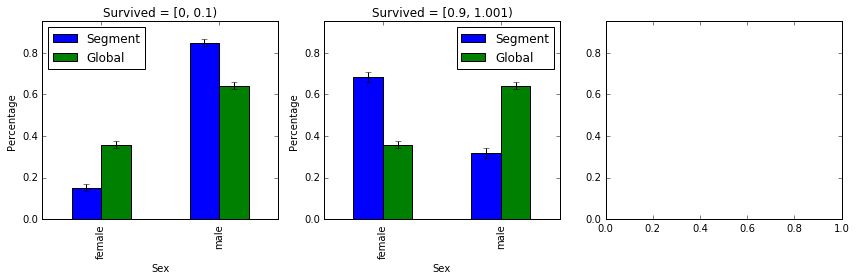

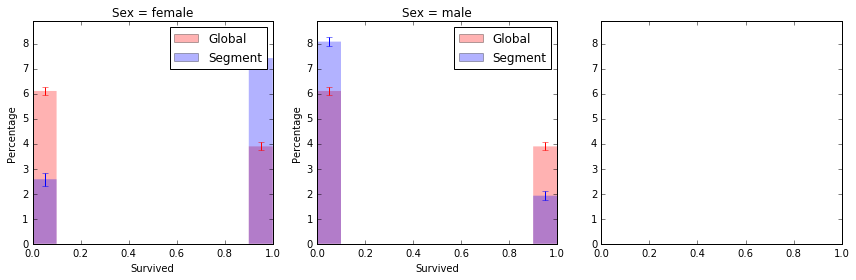

In [210]:
# We'll now drawa histograms of the data for each segment in each column.
for ii in range(len(alldataframes)):
    print "ANALYZING DATAFRAME FROM " + datafilenames[ii] + ":"
    print "===================================================="
    drawComparisonData(alldataframes[ii], datacategories[ii], uselesscolumns[ii], unknowns[ii])

# Correlations

We begin with a scatterplot of the feature we want to predict, versus each column in the data. We then segment the data of each column and find the average value of the predicted column, to find any possible correlation between these. Finally, we search for all correlations between the various segments of the various columns, to see which features of the data are really independent (this is useful for dimensional reduction).

In [ ]:
# NOW WE'LL WORK ON CORRELATIONS
# - Scatterplot: predicted column vs. other column
# - Correlation between segments and prediction column (average of segment)
# - Correlation between segments

In [186]:
thedataframe = alldataframes[0]
xaxcolumn = "Age"
yaxcolumn = "Survived"
uselesscols = uselesscolumns[0]
datacateg = datacategories[0]

if xaxcolumn in unknowns[0]:
    thedataframe = thedataframe[thedataframe[xaxcolumn]!= unknowns[ii][xaxcolumn]]
if yaxcolumn in unknowns[0]:
    thedataframe = thedataframe[thedataframe[yaxcolumn]!= unknowns[0][yaxcolumn]]

In [208]:
# I NEED TO USE NUMERIC COLUMNS FOR SCATTERPLOTS BECAUSE OTHERWISE IT DOENS'T KNOW HOW TO ORDER THEM!
def plotVersusNumeric(thedataframe, yaxcolumn, numericxaxes, datacateg, uselesscols):
    numberofrows = int(np.ceil(len(numericxaxes) / 3.))
    fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
    for (currentax, xaxcolumn) in zip(axes.ravel(), numericxaxes):
        toplotdata = thedataframe.groupby(xaxcolumn)[yaxcolumn].mean()
        xaxis = np.array(toplotdata.index)
        yaxis = np.array(toplotdata.values)
        currentax.scatter(xaxis, yaxis, alpha=0.3, edgecolors="none")
        currentax.set_xlabel(xaxcolumn)
        # We'll now assess whether it would be better to use a log scale for the xaxis.
        # For this we require that all values are positive and that the maximum value
        # is less than 3 times bigger than the size of the bottom 80% of the values.
        numcaseslessthanzero = len(np.where(xaxis<=0)[0])
        if numcaseslessthanzero==0:
            aremostdatapointslow = max(xaxis) / np.percentile((xaxis - min(xaxis)),80) > 3
            if aremostdatapointslow==True:
                currentax.set_xscale("log")
                currentax.set_xlabel(xaxcolumn + " (N.B. Log scale!)")
        currentax.set_ylabel(yaxcolumn)

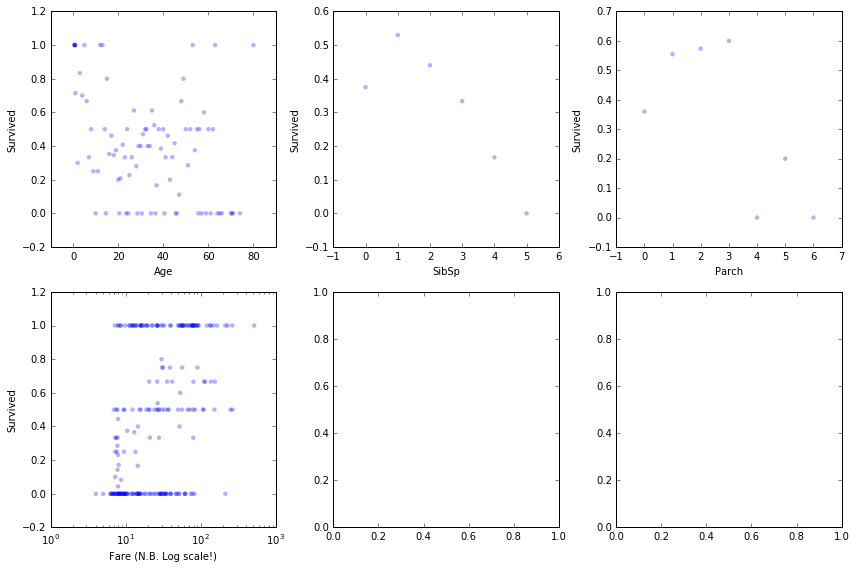

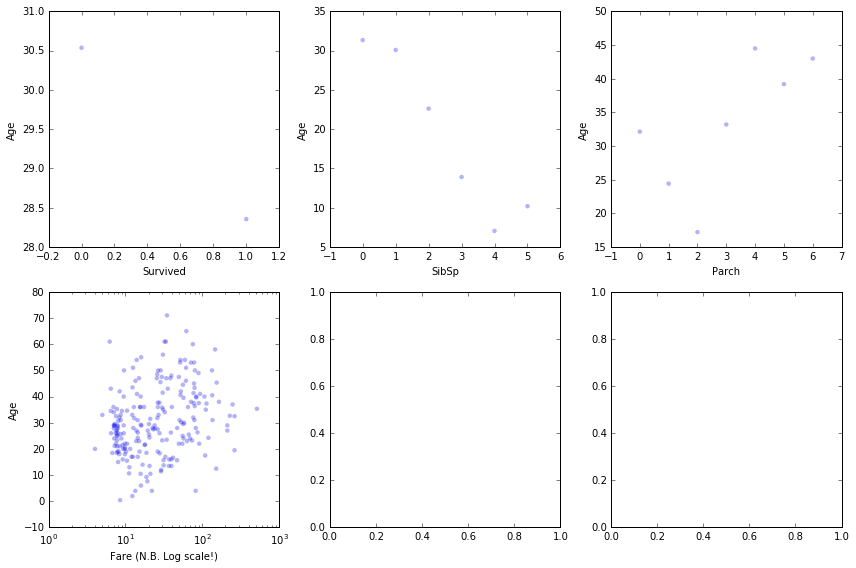

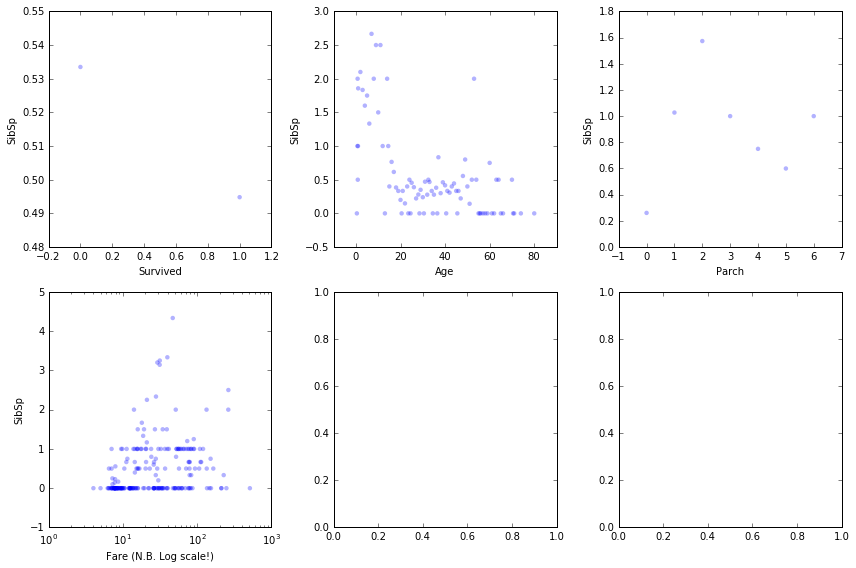

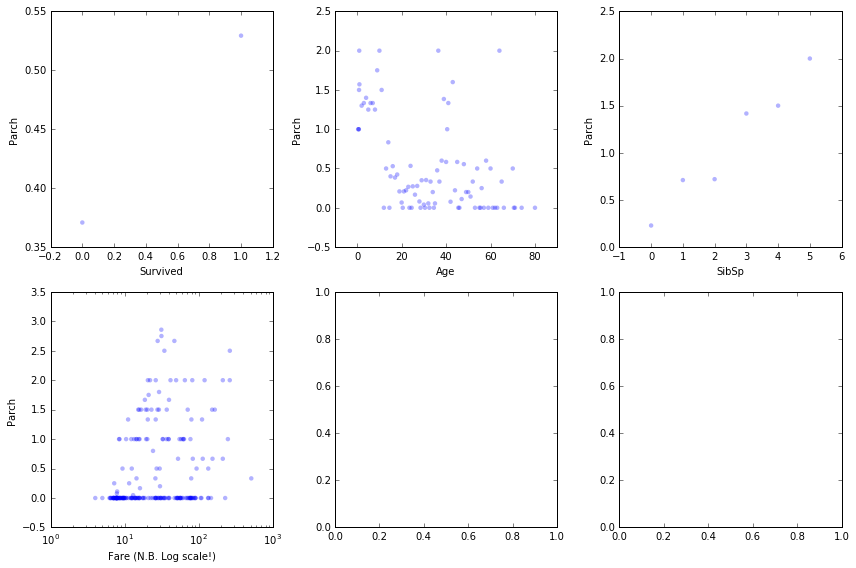

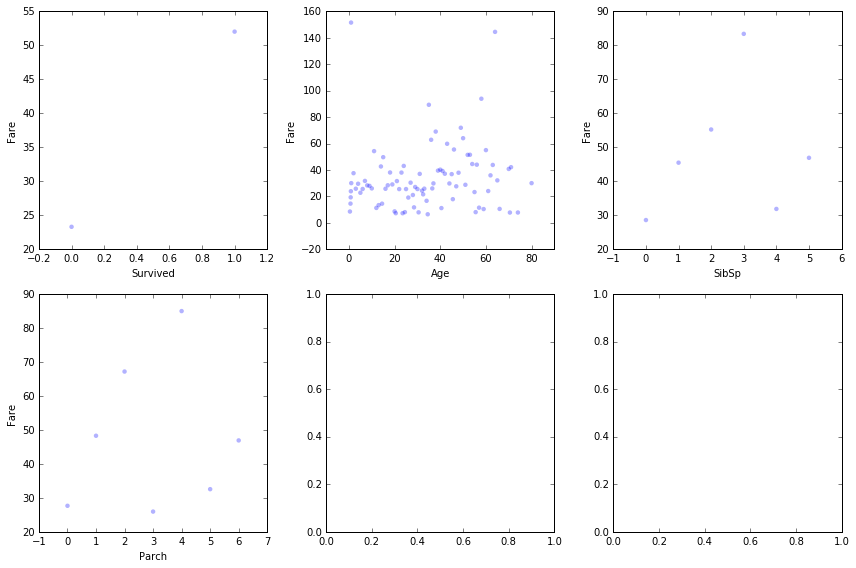

In [211]:
for yaxcolumn in thedataframe:
    if (datacateg[yaxcolumn]=="QA" or datacateg[yaxcolumn]=="QC") \
    and (yaxcolumn not in uselesscols):
        numericxaxes = []
        for xaxcolumn in thedataframe:
            if (datacateg[xaxcolumn]=="QA" or datacateg[xaxcolumn]=="QC") \
            and (xaxcolumn not in uselesscols) and xaxcolumn!=yaxcolumn:
                numericxaxes.append(xaxcolumn)
        numberofrows = int(np.ceil(len(numericxaxes) / 3.))
        fig, axes = plt.subplots(nrows=numberofrows, ncols=3, figsize=(12,4*numberofrows), tight_layout=True)
        for (currentax, xaxcolumn) in zip(axes.ravel(), numericxaxes):
            if (datacateg[xaxcolumn]=="QA" or datacateg[xaxcolumn]=="QC") \
            and (xaxcolumn not in uselesscols) and xaxcolumn!=yaxcolumn:
                toplotdata = thedataframe.groupby(xaxcolumn)[yaxcolumn].mean()
                xaxis = np.array(toplotdata.index)
                yaxis = np.array(toplotdata.values)
                currentax.scatter(xaxis, yaxis, alpha=0.3, edgecolors="none")
                currentax.set_xlabel(xaxcolumn)
                # We'll now assess whether it would be better to use a log scale for the xaxis.
                # For this we require that all values are positive and that the maximum value
                # is less than 3 times bigger than the size of the bottom 80% of the values.
                numcaseslessthanzero = len(np.where(xaxis<=0)[0])
                if numcaseslessthanzero==0:
                    aremostdatapointslow = max(xaxis) / np.percentile((xaxis - min(xaxis)),80) > 3
                    if aremostdatapointslow==True:
                        currentax.set_xscale("log")
                        currentax.set_xlabel(xaxcolumn + " (N.B. Log scale!)")
                currentax.set_ylabel(yaxcolumn)

In [87]:
thedata["Age"][abs(thedata["Age"] - thedata["Age"].mean()) < 0.2].unique()[0]

29.6991176471

In [63]:
thedata = alldataframes[0]

In [6]:
thedata.groupby("Pclass").mean()["Survived"]

Pclass
1    0.644550
2    0.488764
3    0.242300
Name: Survived, dtype: float64

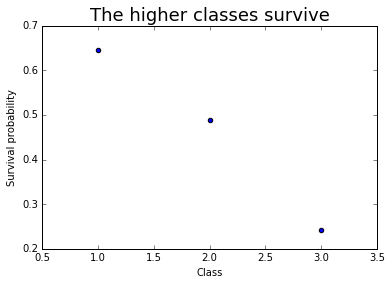

In [7]:
plt.scatter(thedata.groupby("Pclass").mean()["Survived"].index, thedata.groupby("Pclass").mean()["Survived"])
plt.xlabel("Class")
plt.ylabel("Survival probability")
plt.title("The higher classes survive", {"fontsize":18} )
plt.show()

In [8]:
newframe = thedata["Survived"].to_frame()
newframe["AgeGroup"] = pd.cut(thedata["Age"],40)

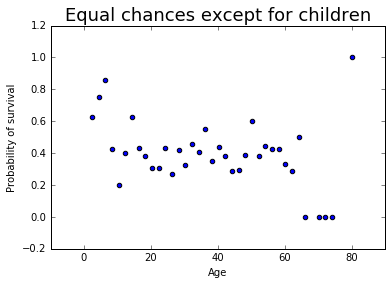

In [9]:
plt.scatter([float(x[x.find(",")+2:-1]) for x in newframe.groupby("AgeGroup").mean()["Survived"].index], newframe.groupby("AgeGroup").mean()["Survived"])
plt.xlabel("Age")
plt.ylabel("Probability of survival")
plt.title("Equal chances except for children", {"fontsize": 18})

In [10]:
thedata.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Nationality
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,XXX,S,United States
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,United States
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,XXX,S,Finland
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,United States
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,XXX,S,United States


<Container object of 2 artists>

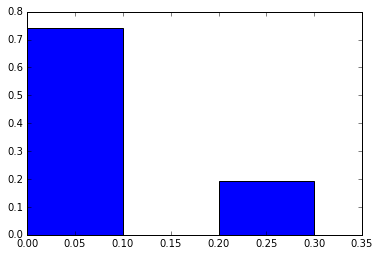

In [11]:
plt.bar([0,0.2],thedata.groupby("Sex").mean()["Survived"],width=0.1)
# Chance for men and women to survive

In [163]:
# What is the distribution of Pclass, Sex, Age, Fare, Nationality?
# Figure out what kind of plot is best for what kind of correlations